In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re

# languange processing imports
import nltk
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
sns.set()  # defines the style of the plots to be seaborn style

In [2]:
train = pd.read_csv(r'./train.csv')
test = pd.read_csv(r'./test.csv')

In [3]:
train.shape,test.shape

((5959, 4), (2553, 3))

In [4]:
train.head()

,Review_Text,Review_Title,topic,Conc
0,"Did nothing for me, didn't help lost even with...",Useless,Shipment and delivery,"Did nothing for me, didn't help lost even with..."
1,"Did nothing for me, didn't help lost even with...",Useless,Not Effective,"Did nothing for me, didn't help lost even with..."
2,I have bought these bags and immediately open...,TRASH!!! Do not buy these bags it’s a waist of...,Customer Service,I have bought these bags and immediately open...
3,Gave me an allergic reaction on my face :(,Do not recommend,Allergic,Gave me an allergic reaction on my face :( Do ...
4,These don't compare to the name brand wipes. F...,Can't tackle big messes,Texture,These don't compare to the name brand wipes. F...


The average number of words in a document is: 57.601275381775466.
The median of words in a document is: 41.0.
The minimum number of words in a document is: 2.
The maximum number of words in a document is: 552.
There are 88 documents with over 150 words.


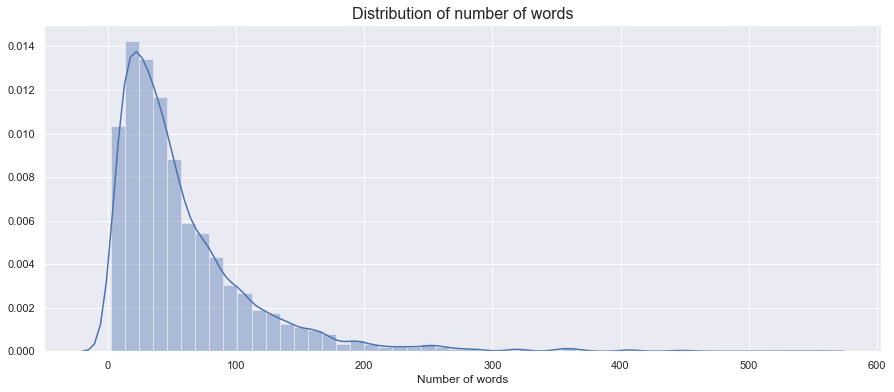

In [5]:
#train data   Review_Text
document_lengths = np.array(list(map(len, train.Conc.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The median of words in a document is: {}.".format(np.median(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

print("There are {} documents with over 150 words.".format(sum(document_lengths > 250)))
shorter_documents = document_lengths[document_lengths <= 250]

fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax);

In [6]:
# find and remove non-ascii words
# I stored our special word in a variable for later use
our_special_word = 'qwerty'

def remove_ascii_words(df):
 

    non_ascii_words = []
    for i in range(len(df)):
        for word in df.loc[i, 'Conc'].split(' '):
            if any([ord(character) >= 128 for character in word]):
                non_ascii_words.append(word)
                df.loc[i, 'Conc'] = df.loc[i, 'Conc'].replace(word, our_special_word)
    return non_ascii_words



non_ascii_words = remove_ascii_words(train)
print("Replaced {} words with characters with an ordinal >= 128 in the train data.".format(len(non_ascii_words)))

Replaced 3522 words with characters with an ordinal >= 128 in the train data.


In [7]:
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [8]:
# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def w2v_preprocessing(df):
  
    df['Conc'] = df.Conc.str.lower()
    df['document_sentences'] = df.Conc.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists


w2v_preprocessing(train)


In [9]:
def lda_get_good_tokens(df):
    df['Conc'] = df.Conc.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.Conc))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

lda_get_good_tokens(train)

In [10]:
#Let's view at the top word frequencies now and get an idea of the words that are used mostly.
tokenized_only_dict = Counter(np.concatenate(train.tokenized_text.values))

tokenized_train = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_train.rename(columns={0: 'count'}, inplace=True)

In [11]:
tokenized_train.sort_values('count', ascending=False, inplace=True)

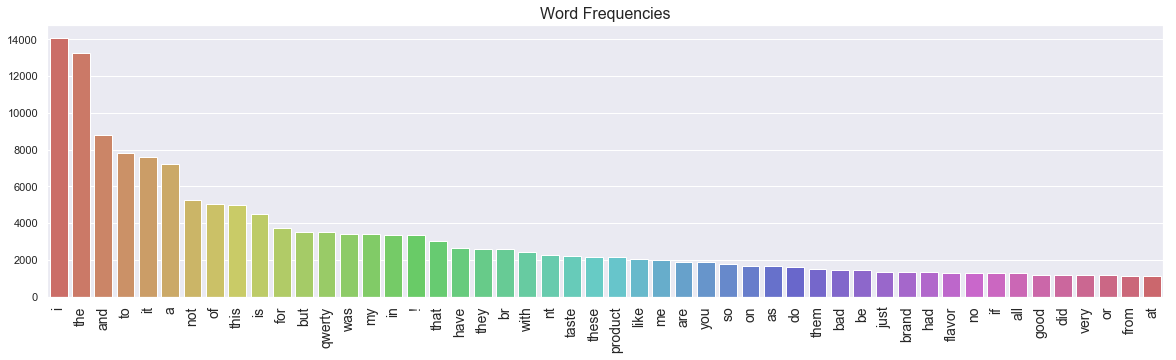

In [12]:
# I made a function out of this since I will use it again later on 
def word_frequency_barplot(df, nr_top_words=50):

    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(tokenized_train)
ax.set_title("Word Frequencies", fontsize=16);

In [13]:
def remove_stopwords(df):

    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('english')
    # we'll add our own special word in here 'qwerty'
    stopwords.append(our_special_word)

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(train)

In [14]:
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

stem_words(train)

In [15]:
dictionary = Dictionary(documents=train.stemmed_text.values)

print("Found {} words.".format(len(dictionary.values())))

Found 6687 words.


In [16]:
dictionary.filter_extremes(no_above=0.8, no_below=3)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 3593 words.


In [17]:
#Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
document_to_bow(train)

In [18]:
# we make a function such that later on when we make the submission, we don't need to write duplicate code
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)

Text(0.5, 1.0, 'Document Frequencies (Number of documents a word appears in)')

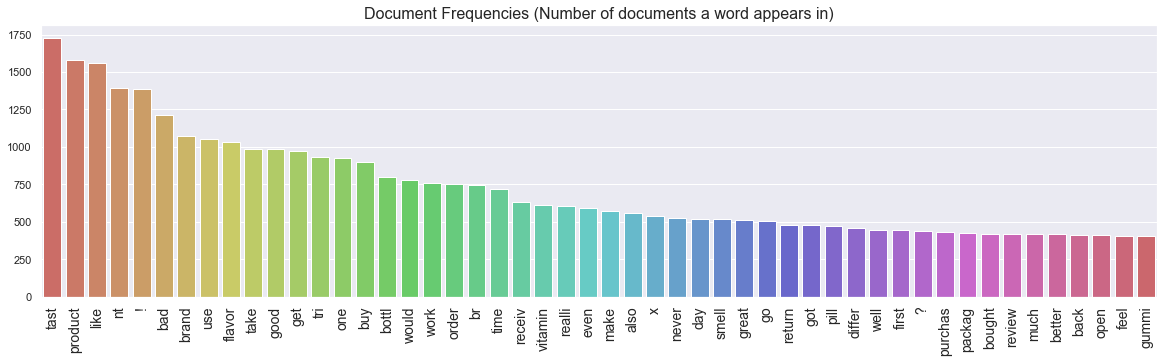

In [112]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

cleansed_words_df.sort_values('count', ascending=False, inplace=True)

ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16)

In [22]:
corpus = train.bow

# %%time
num_topics = 150
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,id2word=dictionary,num_topics=num_topics,workers=16,chunksize=3000,passes=7,alpha='asymmetric')

In [23]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

train['lda_features'] = list(map(lambda doc:document_to_lda_features(LDAmodel, doc),train.bow))


In [24]:
def show_image(base64_encoded_image):
    """ Decodes a base64 encoded image and plots it.
    """
    fig, ax = plt.subplots(figsize=(10,10))

    decoded_image = base64.b64decode(base64_encoded_image)
    img = io.BytesIO(decoded_image)
    img = mpimg.imread(img, format='PNG')

    ax.imshow(img)
    ax.axis('off');

# wordtovec

In [25]:
sentences = []
for sentence_group in train.tokenized_sentences:
    sentences.extend(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(train)))

Number of sentences: 27591.
Number of texts: 5959.


In [26]:
# Set values for various parameters
num_features = 100    # Word vector dimensionality
min_word_count = 3    # Minimum word count
num_workers = 16       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,sg=1,hs=0,workers=num_workers,size=num_features,min_count=min_word_count,window=context,
                    sample=downsampling,negative=5,iter=6)

In [27]:
def get_w2v_features(w2v_model, sentence_group):
 
    words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


In [28]:
train['w2v_features'] = list(map(lambda sen_group:get_w2v_features(W2Vmodel, sen_group),train.tokenized_sentences))

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [29]:
label_encoder = LabelEncoder()

label_encoder.fit(train.topic)
train['topic_id'] = label_encoder.transform(train.topic)

In [30]:
def get_cross_validated_model(model, param_grid, X, y, nr_folds=5):
    """ Trains a model by doing a grid search combined with cross validation.
    args:
        model: your model
        param_grid: dict of parameter values for the grid search
    returns:
        Model trained on entire dataset with hyperparameters chosen from best results in the grid search.
    """
    # train the model (since the evaluation is based on the logloss, we'll use neg_log_loss here)
    grid_cv = GridSearchCV(model, param_grid=param_grid, scoring='neg_log_loss', cv=nr_folds, n_jobs=-1, verbose=True)
    best_model = grid_cv.fit(X, y)
    # show top models with parameter values
    result_df = pd.DataFrame(best_model.cv_results_)
    show_columns = ['mean_test_score', 'mean_train_score', 'rank_test_score']
    for col in result_df.columns:
        if col.startswith('param_'):
            show_columns.append(col)
    display(result_df[show_columns].sort_values(by='rank_test_score').head())
    return best_model

In [32]:
# since train_data['lda_features'] and train_data['w2v_features'] don't have the needed shape and type yet,
# we first have to transform every entry
X_train_lda = np.array(list(map(np.array, train.lda_features)))
X_train_w2v = np.array(list(map(np.array, train.w2v_features)))
X_train_combined = np.append(X_train_lda, X_train_w2v, axis=1)

In [64]:
X=sparse.csr_matrix(X_train_combined)

# tfidf

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
lemma = WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer

In [57]:
def split_into_lemmas(message):
    message=message.lower()
    words = word_tokenize(message)
    words_sans_stop=[]
    for word in words :
        if word in my_stop:continue
        words_sans_stop.append(word)
    return [lemma.lemmatize(word) for word in words_sans_stop]

my_stop=set(stopwords.words('english')+list(punctuation))

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

tf= CountVectorizer(analyzer=split_into_lemmas,min_df=10,max_df=50000,stop_words=my_stop)

In [67]:
tf.fit(train['Conc'])
train_tf1=tf.transform(train['Conc'])

# valid_tf1=tf.transform(x_valid['Conc'])

In [61]:
#Hashing vectorizer
## Word
hash_word = HashingVectorizer(analyzer='word', stop_words= 'english' , ngram_range= (1,3), 
                              token_pattern= r'w{1,}', strip_accents= 'unicode',
                             dtype= np.float32, tokenizer= nltk.tokenize.word_tokenize )
#Char
hash_char = HashingVectorizer(analyzer='char', stop_words= 'english' , ngram_range= (3,6),
                              strip_accents= 'unicode',dtype= np.float32 )

In [63]:
# Word
train_hash = hash_word.transform(train['Conc'])
# valid_hash = hash_word.transform(x_valid['Conc'])
# test_hash = hash_word.transform(test['Conc'])
# char
train_hash_char = hash_char.transform(train['Conc'])
# valid_hash_char = hash_char.transform(x_valid['Conc'])
# test_hash_char = hash_char.transform(test['Conc'])

In [68]:
final = sparse.hstack([train_hash, train_hash_char,train_tf1,X])

In [35]:
# store all models in a dictionary
models = dict()

#model training 

In [41]:
from sklearn.model_selection import train_test_split
x_train,x_valid,y_train,y_valid= train_test_split(X_train_combined,train.topic,test_size=0.2,random_state=2)

# Logistic Regression

In [69]:
# LDA features only
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_lda = get_cross_validated_model(lr, param_grid, final, train.topic_id)

models['best_lr_lda'] = best_lr_lda

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 22.2min finished


,mean_test_score,mean_train_score,rank_test_score,param_penalty
0,-1.212016,-0.710838,1,l1
1,-1.349419,-0.568978,2,l2


In [82]:
# Word2Vec features only
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_w2v = get_cross_validated_model(lr, param_grid, X_train_w2v, train.topic_id)

models['best_lr_w2v'] = best_lr_w2v

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.1s finished


,mean_test_score,mean_train_score,rank_test_score,param_penalty
0,-1.666203,-1.603712,1,l1
1,-1.702623,-1.654975,2,l2


In [83]:
# LDA and Word2Vec combined
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_combined = get_cross_validated_model(lr, param_grid, X_train_combined, train.topic_id)

models['best_lr_combined'] = best_lr_combined

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   27.0s finished


,mean_test_score,mean_train_score,rank_test_score,param_penalty
0,-1.652802,-1.524948,1,l1
1,-1.676023,-1.507017,2,l2


In [84]:
for name, model in models.items():
    print("Model {} has a test score of: {:0.4f}".format(name, float(model.best_score_)))

Model best_lr_lda has a test score of: -1.2120
Model best_lr_w2v has a test score of: -1.6662
Model best_lr_combined has a test score of: -1.6528


# Make a submission

In [70]:
test_data = pd.read_csv('./test.csv')

print(test_data.shape)
test_data.head(3)

(2553, 3)


,Review_Text,Review_Title,Conc
0,I use chia seed in my protein shakes. These ta...,Bad tast,I use chia seed in my protein shakes. These ta...
1,I use chia seed in my protein shakes. These ta...,Bad tast,I use chia seed in my protein shakes. These ta...
2,Don’t waste your money.,No change. No results.,Don’t waste your money. No change. No results.


The average number of words in a document is: 58.42538190364277.
The median of words in a document is: 41.0.
The minimum number of words in a document is: 2.
The maximum number of words in a document is: 538.
There are 35 documents with over 150 words.


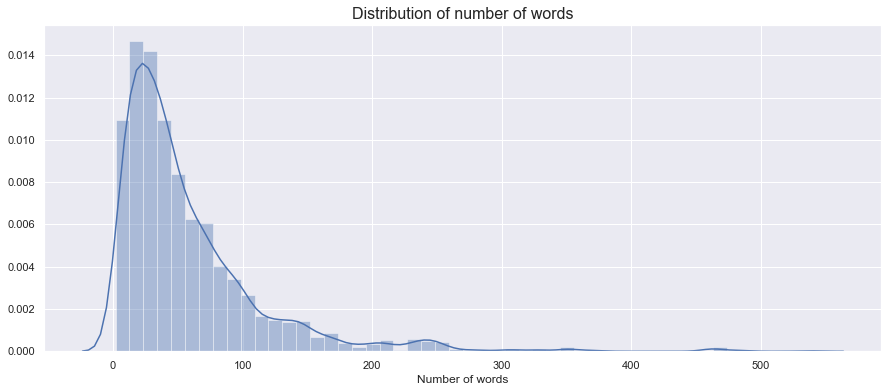

In [108]:
#train data   Review_Text
document_lengths = np.array(list(map(len, test.Conc.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The median of words in a document is: {}.".format(np.median(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

print("There are {} documents with over 150 words.".format(sum(document_lengths > 250)))
shorter_documents = document_lengths[document_lengths <= 250]

fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax);

Text(0.5, 1.0, 'Document Frequencies (Number of documents a word appears in)')

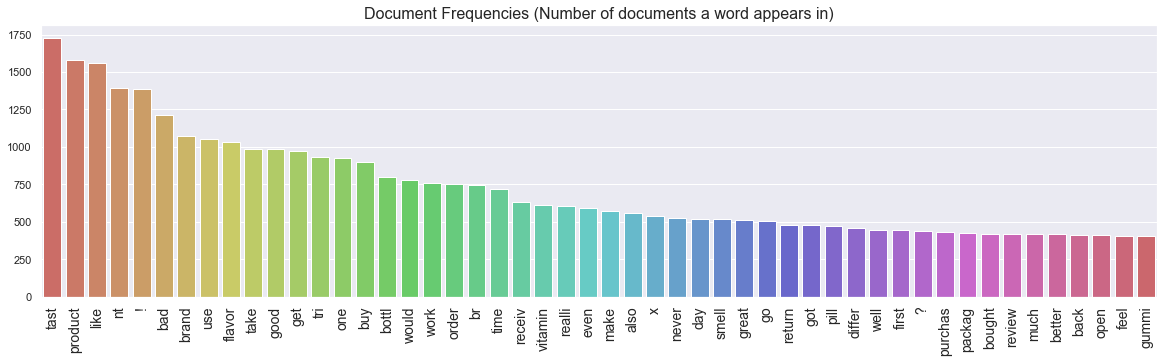

In [113]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

cleansed_words_df.sort_values('count', ascending=False, inplace=True)

ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16)

In [71]:
non_ascii_words = remove_ascii_words(test_data)

print("Replaced {} words with characters with an ordinal >= 128 in the test data.".format(
    len(non_ascii_words)))

Replaced 1376 words with characters with an ordinal >= 128 in the test data.


In [72]:
lda_preprocessing(test_data)
w2v_preprocessing(test_data)

In [73]:
test_data['lda_features'] = list(map(lambda doc:
                                     document_to_lda_features(LDAmodel, doc),
                                     test_data.bow))

test_data['w2v_features'] = list(map(lambda sen_group:
                                     get_w2v_features(W2Vmodel, sen_group),
                                     test_data.tokenized_sentences))

In [74]:
X_test_lda = np.array(list(map(np.array, test_data.lda_features)))
X_test_w2v = np.array(list(map(np.array, test_data.w2v_features)))
X_test_combined = np.append(X_test_lda, X_test_w2v, axis=1)

In [76]:
test_tf1=tf.transform(test['Conc'])

In [77]:
test_hash = hash_word.transform(test['Conc'])
# char
test_hash_char = hash_char.transform(test['Conc'])

In [78]:
Y=sparse.csr_matrix(X_test_combined)

In [79]:
test_final = sparse.hstack([test_hash, test_hash_char,test_tf1,Y])

In [86]:
submission_predictions = best_lr_lda.predict(test_final)

In [94]:
submission_predictions

(2553,)

In [95]:
train['topic_id'] = label_encoder.transform(train.topic)

In [96]:
sub = pd.read_csv(r'./Sample.csv')

In [104]:
sub.head()

,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,1
1,I use chia seed in my protein shakes. These ta...,Bad tast,1
2,Don’t waste your money.,No change. No results.,11
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",10
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",10


In [103]:
sub.topic = submission_predictions

In [105]:
sub.to_csv('sample.csv',index=False)

In [107]:
train.to_csv('final_train.csv',index=False)